# Fast Fourier Transform

Here we will study the fast Fourier transform (FFT) in the context of signal processing.  Other examples will be studied in the lab.

## Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.signal as signal
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

### Signal Processing

Signal processing is a large subject.  We are using it as an example application of FFT methods.  It is not the only application!  Even so, `scipy.signal` is a large module that contains many functions for signal processing and using the FFT in general.  We will mostly *not* use this module since the basic FFT routines are also implemented in the `numpy.fft` module and these are sufficient for our needs.  

### `numpy.fft`

Even this "small" module contains many functions that are useful for us.  We will only use `fft`, `ifft`, `fftshift`, and `fftfreq`.  These will be discussed below as we need them.  The module itself contains functions for higher dimensional FFTs also.

In [2]:
np.fft?

## Noisy Signal

We begin by generating sample data in the form of a noisy signal.  To do so we generate a signal with three dominant frequencies and large Gaussian noise (aka, white noise).

In [3]:
N = 10001
Nf = 3
t = np.arange(N, dtype=float)
# Pick random periods between 200 and 1500 and convert them to frequencies
Ts = np.random.rand(Nf)*1300+200
fs = 1./Ts

# Sort for later convenience
fs.sort()

# Pick random amplitudes
amp = np.random.rand(Nf)*200 + 100

# Pick random phases
phi = np.random.rand(Nf)*2*np.pi

# Calculate signal using broadcasting
h = np.sum( amp[:,None]*np.sin(2*np.pi*t[None,:]*fs[:,None]+phi[:,None]), axis=0 )

# Make a noisy signal by adding white noise
hn = h + np.random.randn(N)*700

To see what we are working with plot the noisy data along with the true signal.

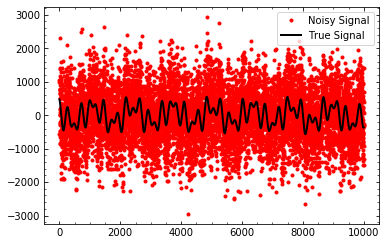

In [4]:
plt.plot(t, hn, 'r.', label='Noisy Signal')
plt.plot(t, h, 'k-', lw=2, label='True Signal')
plt.legend(loc='best', numpoints=1)

Notice that signal is very noisy.  Without the true signal being drawn it would be very hard to guess what it looks like.

### Fourier Analysis

Performing a FFT is straightforward, we just us `np.fft.fft`.

In [5]:
np.fft.fft?

So `fft` returns the (discrete) Fourier transform, but how is it organized?  The order in which the positive and negative frequencies are stored is given by `np.fft.fftfreq`.

In [6]:
np.fft.fftfreq?

Notice that the zero frequency (DC level) is the first entry, then the positive ones, then the negative ones in reverse order.  For an odd number of samples the positive and negative frequencies are symmetric.  Here we calculate the FFT and look at the frequencies.

In [7]:
Hn = np.fft.fft(hn)
f = np.fft.fftfreq(N)
print(f)

[ 0.00000000e+00  9.99900010e-05  1.99980002e-04 ... -2.99970003e-04
 -1.99980002e-04 -9.99900010e-05]


The ordering is particularly convenient.  Notice that using array slicing we can easily pull out the positive and negative frequencies.

In [8]:
ind = np.arange(1,N//2+1) # Need integer division!
print(f[ind])
print(f[-ind])

[9.99900010e-05 1.99980002e-04 2.99970003e-04 ... 4.99750025e-01
 4.99850015e-01 4.99950005e-01]
[-9.99900010e-05 -1.99980002e-04 -2.99970003e-04 ... -4.99750025e-01
 -4.99850015e-01 -4.99950005e-01]


This is particularly useful for calculating the amplitudes in the signal, which combines the positive and negative frequencies.  We can use this to identify which frequencies dominate the signal.

(0.0, 0.02)

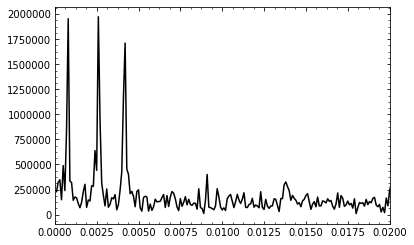

In [9]:
amp = np.abs(Hn[ind]) + np.abs(Hn[-ind])
plt.plot(f[ind], amp, 'k-')
# By construction we expect the frequencies to be small, so limit the plot
# to the low frequencies so we can see them.
plt.xlim(0.0, 0.02)

The dominant frequencies are those with the largest amplitudes.  What we mean by large is system dependent.  For the data we have constructed we know there are only going to be a few frequencies.  Looking at the figure we can pick an appropriate limit based on the peaks that are much larger than the rest.

In [10]:
print("Dominant frequencies:", f[ind[np.where(amp>1.0e6)]]) # SET LIMIT BY HAND
print("True frequencies:    ", fs)

Dominant frequencies: [0.00079992 0.00259974 0.00409959 0.00419958]
True frequencies:     [0.00076753 0.00263122 0.0041569 ]


The dominant frequencies we find will not be exactly equal to the true ones.  In fact, we may not even find the same number of frequencies, why not?  Recall that the signal has been discretized.  This means a discrete set of frequencies are contained in the signal.  Each value of the frequency in the digital signal actually corresponds to a range of frequencies in the analog signal.  If two of the true frequencies are too close to each other they could appear as a single digital frequency.  On the other hand, if the true frequency falls roughly halfway between two digital frequencies power will appear at both of them in the digitized signal.

### Gaussian Smoothing

Now that we have identified the frequencies, how to do we extract to true signal from the noise?  One way is to smooth the signal.  We expect our signal to be dominated by low frequencies so we can reduce the power in high frequency modes by averaging the signal over some time scale. As a simple example, we could replace the signal by averaging the 11 time bins centered on each measured time.  This would be "top hat" window function.  It would remove information on scales smaller than 11 times the sampling rate.  There are many other window functions that can be used.  A large selection of them are defined in `scipy.signal`.

What we are describing here is a convolution.  Let $g(t)$ be our window function.  As we saw in class, the convolution is defined by

$$ ( h \otimes g ) (t) \equiv \int_{-\infty}^\infty h(\tau) g(t-\tau)\, \mathrm{d}\tau. $$

Though this can be calculated in the time domain (and there are functions that do this) it is often more efficient to calculate this in the frequency domain.  Let $H$ and $G$ be the Fourier transforms of $h$ and $g$, respectively.  The convolution in the frequency domain is just the product of these Fourier transforms, $HG$, no integral required.  To calculate the convolution we can thus

1. Calculate the Fourier transforms of $h$ and $g$ which we call $H$ and $G$.
2. Calculate the product $HG$. (This is easy!)
3. Calculate the inverse Fourier transform of $HG$ to produce the convolution $h \otimes g$.

This requires the calculate of a two Fourier transforms and an inverse transform.  Even so, since the FFT is so fast this is typically much faster than performing the calculation in the time domain when the number of samples is larger than a few hundred.

As an example we will consider smoothing by a Gaussian,

$$ g(t) = \frac1{\sqrt{2\pi}\sigma} \exp\!\left( - \frac{t^2}{2\sigma^2} \right). $$

#### Convolution by Hand

We can directly calculate this convolution by following the above steps.  The width of the Gaussian determines the scale over which the smoothing occurs, a large $\sigma$ means a large smoothing scale.  Here we create a Gaussian with $\sigma=100$.

C:\Users\James\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


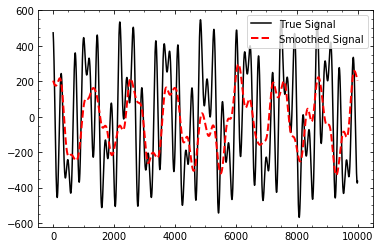

In [11]:
sigma = 100.
tt = np.arange(-N/2, N/2)
g = np.exp(-tt**2/(2*sigma**2)) / np.sqrt(2*np.pi) / sigma
G = np.fft.fft(g)
conv1 = Hn*G
hg1 = np.fft.ifft(conv1)
plt.plot(t, h, 'k-', label='True Signal')
plt.plot(t, hg1, 'r--', lw=2, label='Smoothed Signal')
plt.legend(loc='best')

So the curve is nice and smooth so the noise has been removed, but **the smoothed signal does not look like the true signal**.  What happened?

The problem is that a Fourier series assumes the signal is periodic.  When we perform a convolution what happens when we try to include times outside the range of observations (off the left and right of the plot)?  For the FFT it "wraps around" pulling information from the beginning of the signal when we are smoothing the values and the end and vice-versa at the beginning of the signal.  How do we prevent this from happening?  We use zero padding!

### Zero Padding

Zero padding is exactly as the name sounds, we increase the size of our array and fill it with zeros.  Now when the FFT tries to go past the end of the true signal it hits zeros.  This can be implemented in a few ways.  We could do so directly by creating a larger array, putting the true signal in part of this array and zeros in the rest.  Alternatively we can just let `fft` do the work for us.  Again check the documentation and note the `n` keyword.  This does precisely what we want.

Here we use zero padding by (effectively) doubling the size of the input arrays.  Of course this also doubles the size of the final result, our smoothed signal, so where is the true signal?  A quick plot shows us the answer.

**Note:** This is one use for zero padding.

C:\Users\James\Anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)
C:\Users\James\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


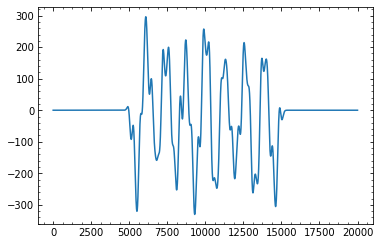

In [12]:
Hz = np.fft.fft(hn, n=2*N)
Gz = np.fft.fft(g, n=2*N)
conv2 = Hz*Gz
hg2 = np.fft.ifft(conv2)
plt.plot(hg2)

Notice that the smoothed signal appears in the middle of the array produced by the calculation.  In practice where it appears depends on how we perform the zero padding.  The approach we used for calculating the FFT put the zero padding after the true signal.  Alternatively we could have put the padding before the true signal, center the true signal between zero padding, or split up the zeros however we like.  These choices will just move the smoothed signal left and right in the result, but does not affect its shape.  Here we pull out the smoothed signal and see that this does a much better job of reproducing the true one.

C:\Users\James\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


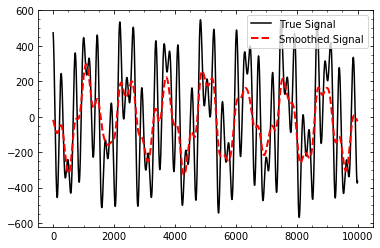

In [13]:
plt.plot(t, h, 'k-', label='True Signal')
plt.plot(t, hg2[N//2:3*N//2], 'r--', lw=2, label='Smoothed Signal')
plt.legend(loc='best')
plt.minorticks_on()

### `scipy.signal.fftconvolve`

There are a number of functions that will calculate the convolution for us.  Some do so in the time domain, some use the Fourier transform.  Here only briefly mention one based on the FFT.  It does all the steps, with zero padding, for us so is much easier to use.

In [14]:
signal.fftconvolve?

C:\Users\James\Anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


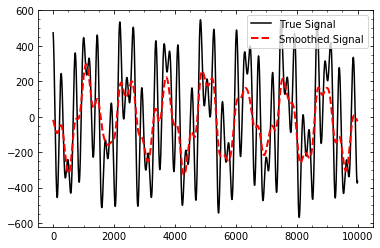

In [15]:
# Redo using scipy.signal.fftconvolve
hg3 = signal.fftconvolve(hn, g, mode='same')
plt.plot(t, h, 'k-', label='True Signal')
plt.plot(t, hg3, 'r--', lw=2, label='Smoothed Signal')
plt.legend(loc='best')
plt.minorticks_on()

Notice that the smoothed signal calculated by `signal.fftconvolve` looks exactly like the one we calculated by hand with zero padding.

### Low Pass Filter

Another very powerful use of the FFT is to filter signals in the frequency domain.  Again, there are many, many filters that have been defined for many, many reasons.  Again, quite a few of these are implemented in `scipy.signal`.  For our purpose here we will look at a very simple low pass filter.

As the name suggests, a low pass filter only keeps the low frequencies in a signal.  To achieve this we can set the coefficients of all the high frequency terms to zero.  For our signal we only expect the low frequencies to contribute to the true signal, so we set an arbitrary cutoff in the frequency domain.  Keep in mind that the frequencies can be positive or negative!

The basic procedure is again straightforward:
1. Calculate the FFT of the signal.
2. Apply the filter in frequency space to this Fourier transformed signal.
3. Perform an inverse FFT to reconstruct the filtered signal in the time domain.

Here we apply these steps to our noisy signal.

C:\Users\James\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


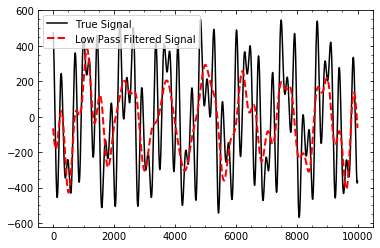

In [16]:
Hf = Hn.copy() # We do NOT just use Hf = Hn, why not?
Hf[np.abs(f) > 0.0025] = 0
hf = np.fft.ifft(Hf)
plt.plot(t, h, 'k-', label='True Signal')
plt.plot(t, hf, 'r--', lw=2, label='Low Pass Filtered Signal')
plt.legend(loc='best')

Notice that this does a reasonably good job of extracting the true signal from the noise.

### Aliasing

We can also consider what frequency-space resolution we need to correctly sample a signal: for too large a sample spacing, we cannot resolve features smaller than a certain size. Below we explore what happens as we sample the function with fewer samples. We find that we need to sample our signal with at least twice the sample rate as the frequency, or we need to sample a sinusoid at least twice per period. This limiting frequency is referred to as the *Nyquist frequency*.

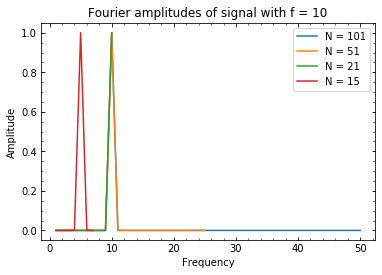

In [17]:
def plot_fft(n, f) :
    ts = np.arange(n)/n
    hs = np.sin(2*np.pi*f*ts)

    Hs = np.fft.fft(hs)
    fs = np.fft.fftfreq(n, 1/n)
    ind = np.arange(1, n//2+1)
    psd = ( np.abs(Hs[ind]/n) + np.abs(Hs[-ind]/n) )
    plt.plot(fs[ind], psd, label="N = "+str(n))

f = 10
plot_fft(101, f)
plot_fft(51, f)
plot_fft(21, f)
plot_fft(15, f) # Aliased signal!
plt.legend()
plt.title("Fourier amplitudes of signal with f = "+str(f))
plt.ylabel("Amplitude")
plt.xlabel("Frequency");